In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, desc, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#inspector
inspector = inspect(engine)
table_names = inspector.get_table_names()
Base = automap_base()
Base.prepare(autoload_with = engine)
Base.classes.keys()


['station', 'measurement']

In [6]:
# reflect an existing database into a new model
measurement = Base.classes.measurement
station = Base.classes.station
# reflect the tables
station

sqlalchemy.ext.automap.station

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
columns = inspector.get_columns('station')
for col in columns:
    print (col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(desc(measurement.date)).first()

('2017-08-23',)

<Axes: xlabel='year'>

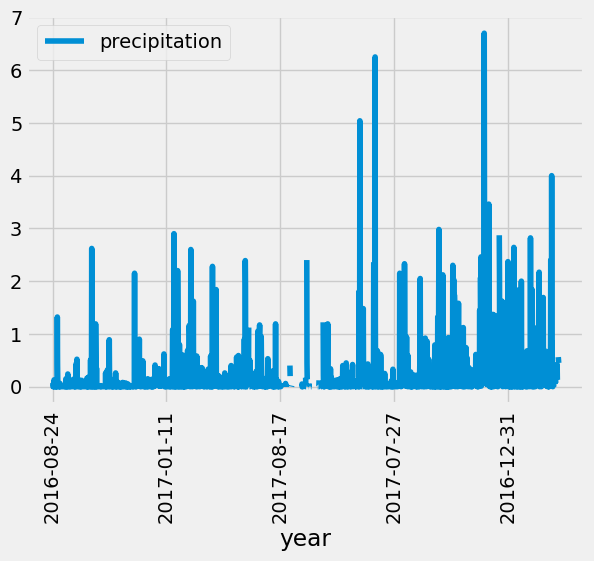

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
date = session.query(measurement.date).order_by(desc(measurement.date)).first()
dt.datetime.strptime(date[0], '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
past_year = dt.datetime.strptime(date[0], '%Y-%m-%d') - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
past_year_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= past_year).all()
past_year_data
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(past_year_data, columns = ['year', 'precipitation'])
prcp_df
# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x = 'year', y = 'precipitation', rot = 90)


In [12]:
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [14]:
columns = inspector.get_columns('station')
for col in columns:
    print (col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number of stations in the dataset
session.query(measurement.station).distinct().count()

9

In [16]:
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.



In [18]:
most_active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).first()
most_active_station[0]
session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == most_active_station[0]).all()
# session.query(station.name).filter(station.station == measurement.station[0]).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [25]:
most_active_station_id = most_active_station[0]
most_active_station_latest_date = session.query(measurement.date).order_by(desc(measurement.date)).first()
most_active_station_latest_date = dt.datetime.strptime(most_active_station_latest_date[0], '%Y-%m-%d')
# most_active_station_past_year = most_active_station_latest_date - dt.timedelta(365)
most_active_station_past_year_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= past_year).all()
prcp_df = pd.DataFrame(most_active_station_past_year_data, columns = ['date', 'temp'])
prcp_df.values.tolist()

[['2016-08-24', 79.0],
 ['2016-08-25', 80.0],
 ['2016-08-26', 79.0],
 ['2016-08-27', 77.0],
 ['2016-08-28', 78.0],
 ['2016-08-29', 78.0],
 ['2016-08-30', 79.0],
 ['2016-08-31', 80.0],
 ['2016-09-01', 81.0],
 ['2016-09-02', 80.0],
 ['2016-09-03', 79.0],
 ['2016-09-04', 75.0],
 ['2016-09-05', 79.0],
 ['2016-09-06', 76.0],
 ['2016-09-07', 76.0],
 ['2016-09-08', 80.0],
 ['2016-09-09', 79.0],
 ['2016-09-10', 78.0],
 ['2016-09-11', 76.0],
 ['2016-09-12', 78.0],
 ['2016-09-13', 78.0],
 ['2016-09-14', 75.0],
 ['2016-09-15', 79.0],
 ['2016-09-16', 80.0],
 ['2016-09-17', 79.0],
 ['2016-09-18', 81.0],
 ['2016-09-19', 77.0],
 ['2016-09-20', 77.0],
 ['2016-09-21', 78.0],
 ['2016-09-22', 76.0],
 ['2016-09-23', 82.0],
 ['2016-09-24', 81.0],
 ['2016-09-25', 78.0],
 ['2016-09-26', 80.0],
 ['2016-09-27', 80.0],
 ['2016-09-28', 79.0],
 ['2016-09-29', 80.0],
 ['2016-09-30', 80.0],
 ['2016-10-01', 80.0],
 ['2016-10-02', 79.0],
 ['2016-10-03', 79.0],
 ['2016-10-04', 79.0],
 ['2016-10-05', 80.0],
 ['2016-10-

(array([ 10.,  17.,  66.,  85., 258., 246., 290., 591., 356., 283.,  18.,
          3.]),
 array([58.        , 60.41666667, 62.83333333, 65.25      , 67.66666667,
        70.08333333, 72.5       , 74.91666667, 77.33333333, 79.75      ,
        82.16666667, 84.58333333, 87.        ]),
 <BarContainer object of 12 artists>)

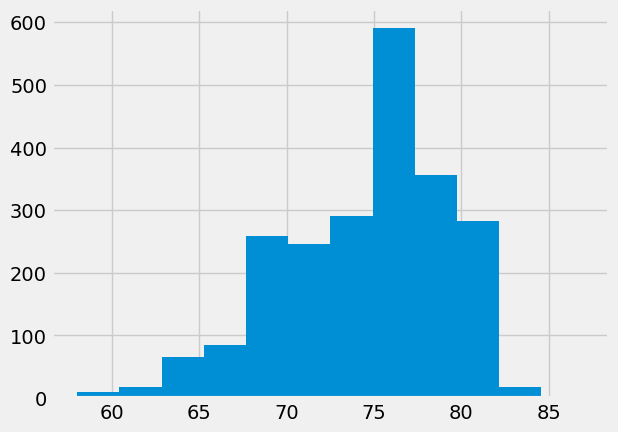

In [39]:
plt.hist(prcp_df['temp'], bins = 12, label='tobs')

Text(0.5, 4.183333333333314, 'Temperature')

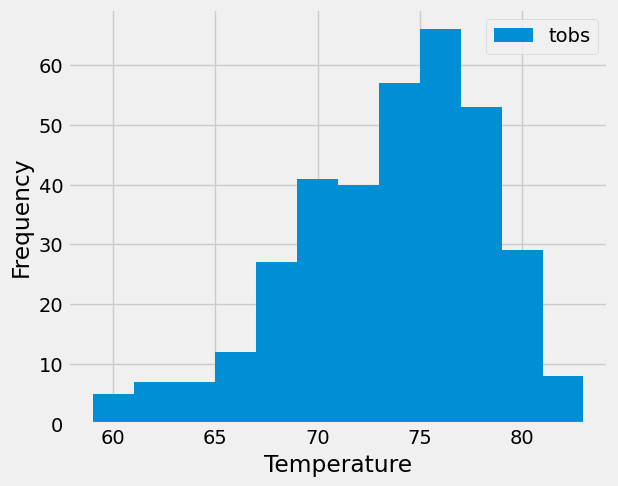

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [26]:
# Close Session
session.close()